In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [16]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [17]:
train_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


# Data Preprocessing

In [18]:
train_data.info()
print(train_data['person_home_ownership'].unique())
print(train_data['loan_intent'].unique())
print(train_data['loan_grade'].unique())
print(train_data['cb_person_default_on_file'].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

# Exploratory Data Analysis

In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

## Outlier Removal

<Axes: xlabel='loan_status', ylabel='person_age'>

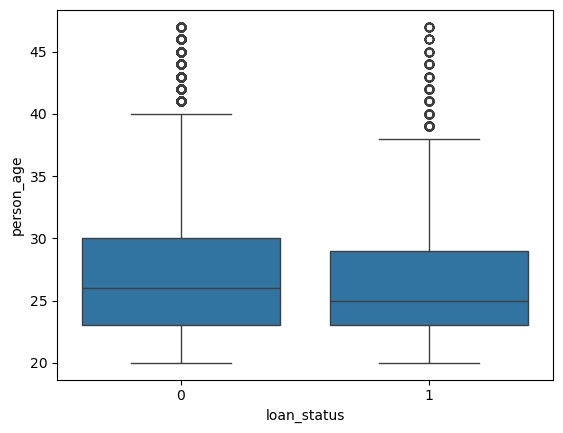

In [21]:
# BoxPlot for Age and loan percent income
import seaborn as sns

Q1 = train_data['person_age'].quantile(0.25)
Q3 = train_data['person_age'].quantile(0.75)
IQR = Q3 - Q1

# Calculate outlier bounds
lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2.5 * IQR

# Filter data to remove outliers
train_data_og = train_data[(train_data['person_age'] >= lower_bound) & (train_data['person_age'] <= upper_bound)]

sns.boxplot(x='loan_status',y='person_age',data=train_data_og)

In [22]:
status_counts = train_data.groupby(['loan_grade', 'loan_status'])['loan_status'].count().unstack(fill_value=0)
status_counts['ratio_1_to_0'] = status_counts[1] / status_counts[0]
print(status_counts[[1, 0, 'ratio_1_to_0']])

loan_status     1      0  ratio_1_to_0
loan_grade                            
A            1032  19952      0.051724
B            2087  18313      0.113963
C            1494   9542      0.156571
D            2988   2046      1.460411
E             631    378      1.669312
F              91     58      1.568966
G              27      6      4.500000


In [23]:
status_counts = train_data.groupby(['loan_intent', 'loan_status'])['loan_status'].count().unstack(fill_value=0)
status_counts['ratio_1_to_0'] = status_counts[1] / status_counts[0]
print(status_counts[[1, 0, 'ratio_1_to_0']])

loan_status           1      0  ratio_1_to_0
loan_intent                                 
DEBTCONSOLIDATION  1729   7404      0.233522
EDUCATION          1322  10949      0.120742
HOMEIMPROVEMENT    1091   5189      0.210252
MEDICAL            1949   8985      0.216917
PERSONAL           1330   8686      0.153120
VENTURE             929   9082      0.102290


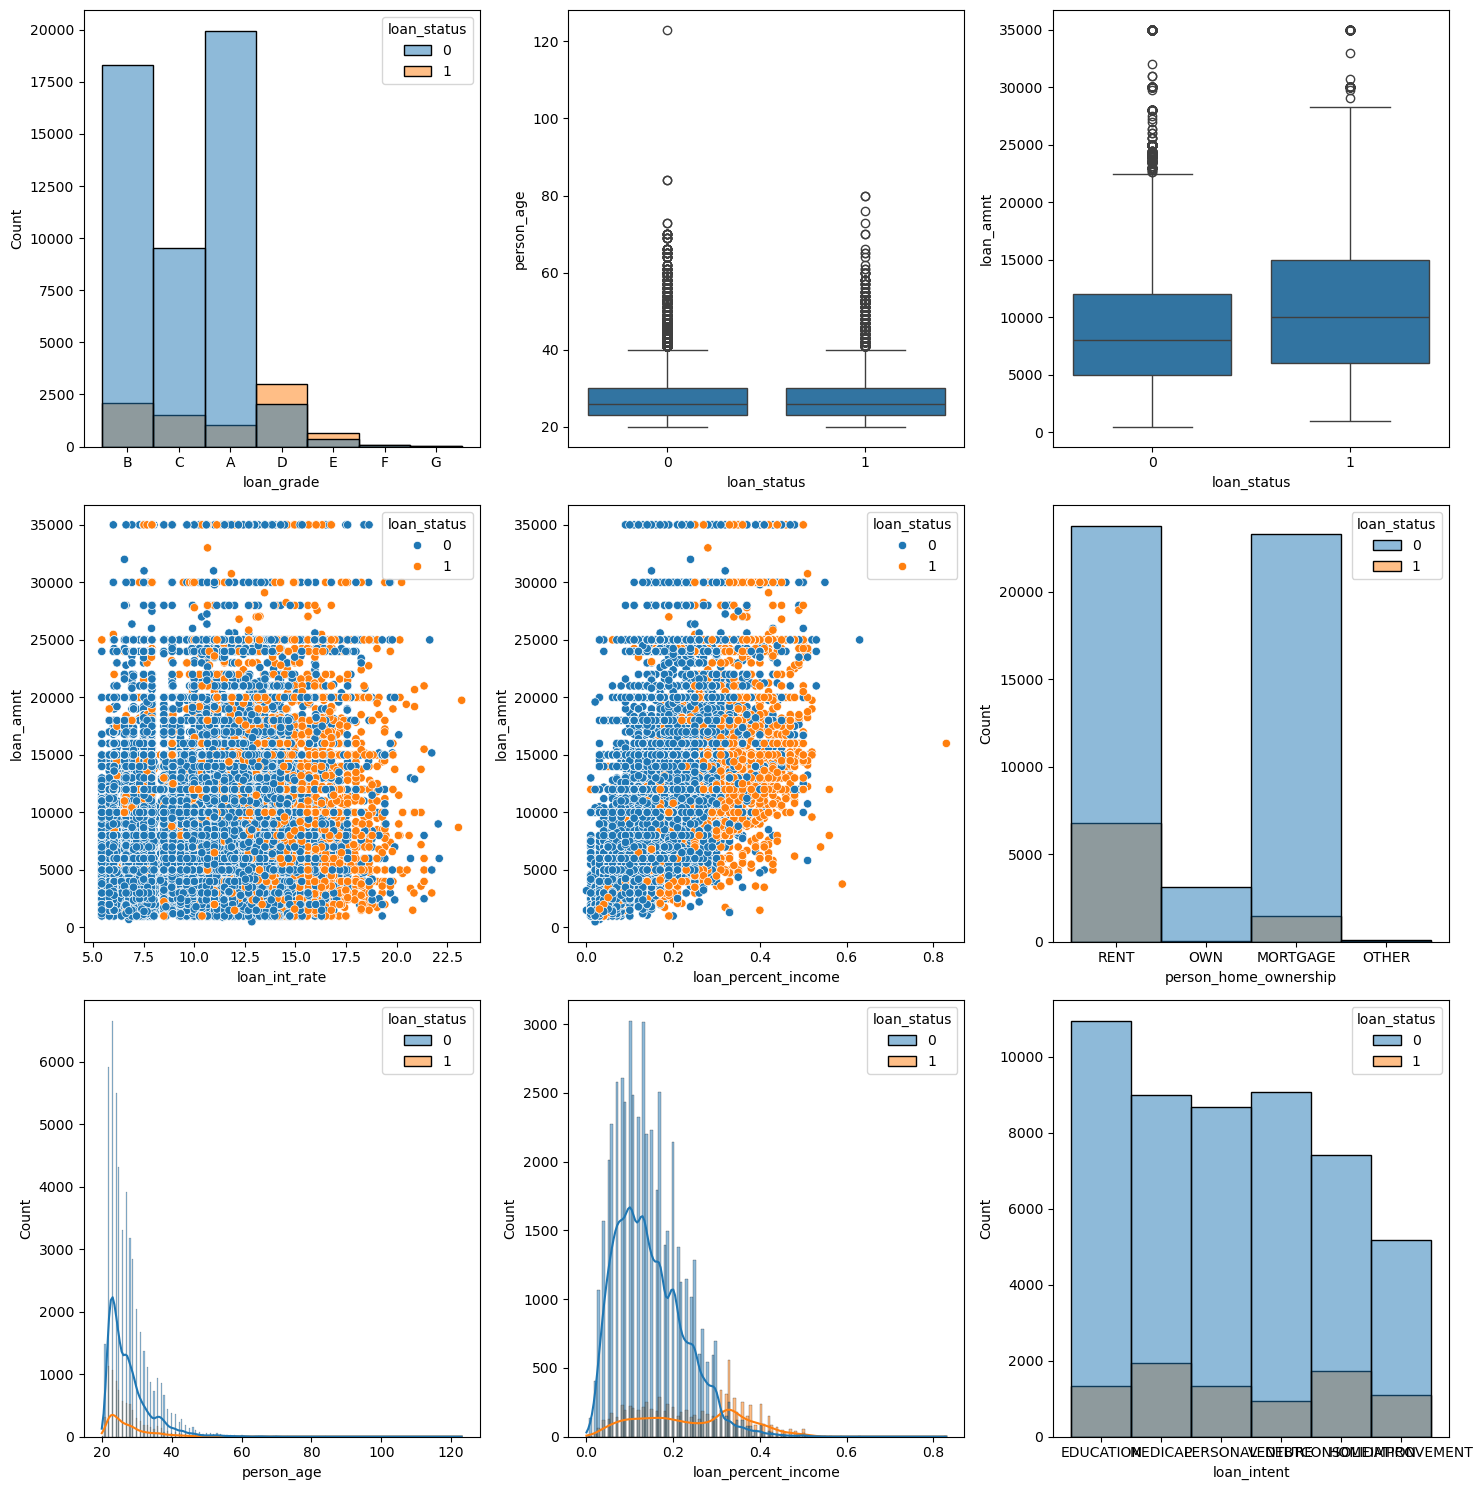

In [24]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3 rows and 3 columns

# Hist plot for  person age and loan_status
sns.histplot(x='loan_grade',hue='loan_status', data=train_data, ax=axes[0,0])

# Boxplot for person age vs loan status
sns.boxplot(x='loan_status', y='person_age', data=train_data, ax=axes[0, 1])

# Boxpot for loan amount vs Loan Status
sns.boxplot(x='loan_status',y='loan_amnt',data=train_data,ax=axes[0,2])

# Scatterplot for loan interest rate vs loan amount
sns.scatterplot(x='loan_int_rate', y='loan_amnt', data=train_data, hue='loan_status', ax=axes[1, 0])

# Violing plot for  cb_person_cred_hist_length and loan_status
sns.scatterplot(y='loan_amnt',x='loan_percent_income',hue='loan_status', data=train_data, ax=axes[1,1])

# Histplot
sns.histplot(x='person_home_ownership',hue='loan_status', data=train_data, ax=axes[1,2])

# Hist plot for  person age and loan_status
sns.histplot(x='person_age',hue='loan_status', data=train_data,kde=True, ax=axes[2,0])

# Hist plot for  person age and loan_status
sns.histplot(x='loan_percent_income',hue='loan_status', data=train_data,kde=True, ax=axes[2,1])

# Hist plot for  person age and loan_status
sns.histplot(x='loan_intent',hue='loan_status', data=train_data, ax=axes[2,2])

plt.tight_layout()
plt.show()

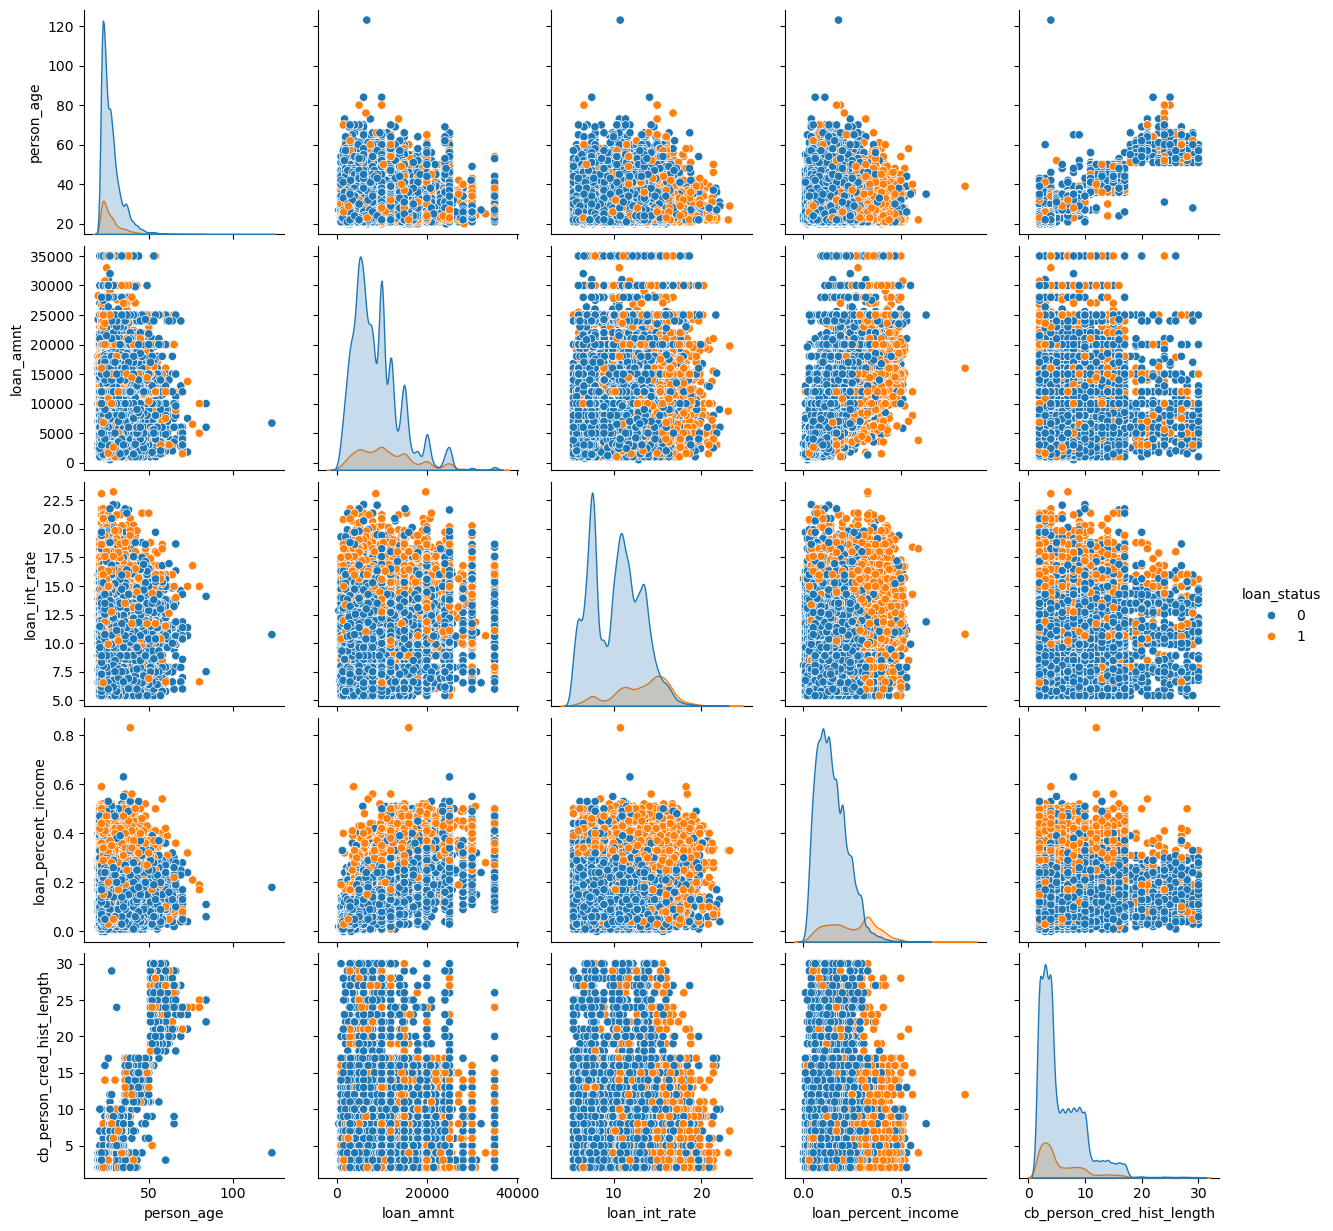

In [25]:
sns.pairplot(train_data.drop(columns=['id','person_emp_length','person_income']), hue="loan_status")

# Feature Engineering

In [50]:
# Train-Test Split
X = train_data.drop(columns=['loan_status','id'])
y = train_data['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Ordinal Encoding
def Ownership(data):
    ownership_mapping = {
        'OTHER': 0,
        'RENT': 1,
        'MORTGAGE': 2,
        'OWN': 3
    }
    data['person_home_ownership'] = data['person_home_ownership'].map(ownership_mapping)

def Intent(data):
    intent_mapping = {
        'DEBTCONSOLIDATION': 6,
        'VENTURE': 0,
        'EDUCATION': 1,
        'PERSONAL': 2,
        'HOMEIMPROVEMENT': 3,
        'MEDICAL': 4
    }
    data['loan_intent'] = data['loan_intent'].map(intent_mapping)

def grade(data):
    grading = {
        'A': 0,
        'B': 1,
        'C': 2,
        'D': 3,
        'E': 4,
        'F': 5,
        'G': 6,
    }
    data['loan_grade'] = data['loan_grade'].map(grading)

def mpping(data):
    mpping = {
        'Y': 1,
        'N': 0,
    }
    data['cb_person_default_on_file'] = data['cb_person_default_on_file'].map(mpping)

Ownership(X_train)
Intent(X_train)
grade(X_train)
mpping(X_train)
Ownership(X_test)
Intent(X_test)
grade(X_test)
mpping(X_test)

### Defining Feature Engineering Functions

In [52]:
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures as SKPolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

def Normalize(X_train, X_test):
    int_columns = X_train.select_dtypes(include=['int','float64']).columns
    scaler = MinMaxScaler()
    X_train_scaled = X_train.copy()  
    X_test_scaled = X_test.copy()   
    X_train_scaled[int_columns] = scaler.fit_transform(X_train[int_columns])  
    X_test_scaled[int_columns] = scaler.transform(X_test[int_columns])       
    return X_train_scaled, X_test_scaled

def Binning(X_train, X_test, bins=5):
    int_columns = X_train.select_dtypes(include=['int', 'float64']).columns
    X_train_binned = X_train.copy()
    X_test_binned = X_test.copy()

    for column in int_columns:
        bin_edges = np.linspace(X_train_binned[column].min(), X_train_binned[column].max(), bins + 1)
        X_train_binned[column] = np.digitize(X_train_binned[column], bin_edges) - 1
        X_test_binned[column] = np.digitize(X_test_binned[column], bin_edges) - 1

    return X_train_binned, X_test_binned

def PolynomialFeatures(X_train, X_test, degree=2):
    int_columns = X_train.select_dtypes(include=['int', 'float64']).columns
    poly = SKPolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = X_train.copy()
    X_test_poly = X_test.copy()
    if len(int_columns) > 0:
        X_train_poly[int_columns] = poly.fit_transform(X_train[int_columns])
        X_test_poly[int_columns] = poly.transform(X_test[int_columns])
    return X_train_poly, X_test_poly

def DateTimeFeatures(X_train,X_test):
    pass

def PrincipalComponentAnalysis(X_train,X_test,n_components):
    int_columns = X_train.select_dtypes(include=['int', 'float64']).columns
    pca = PCA(n_components=n_components)
    X_train_pca = X_train.copy()
    X_test_pca = X_test.copy()
    if len(int_columns) > 0:
        X_train_pca[int_columns] = pca.fit_transform(X_train[int_columns])
        X_test_pca[int_columns] = pca.transform(X_test[int_columns])
    return X_train_pca, X_test_pca

def FeatureImportance(X_train, X_test, y_train):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    return feature_importance_df

# X_train,X_test = Binning(X_train, X_test, bins=)
X = FeatureImportance(X_train,X_test,y_train)
X

,Feature,Importance
8,loan_percent_income,0.235542
5,loan_grade,0.134566
7,loan_int_rate,0.129050
1,person_income,0.110619
2,person_home_ownership,0.095065
4,loan_intent,0.071901
6,loan_amnt,0.067983
3,person_emp_length,0.064610
0,person_age,0.044195
10,cb_person_cred_hist_length,0.035844


In [53]:
X_train.drop(columns=['cb_person_cred_hist_length','cb_person_default_on_file'],inplace=True)
X_test.drop(columns=['cb_person_cred_hist_length','cb_person_default_on_file'],inplace=True)

# Training The Data

In [78]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(confusion)
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f'AUC Score: {auc_score}')


Accuracy: 0.9531929405746441
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10087
           1       0.90      0.75      0.82      1642

    accuracy                           0.95     11729
   macro avg       0.93      0.87      0.90     11729
weighted avg       0.95      0.95      0.95     11729

Confusion Matrix:
[[9955  132]
 [ 417 1225]]
AUC Score: 0.9554814043521727


In [80]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import roc_curve,roc_auc_score

def optimize_xgb(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.05, 0.1],
    }


    model = XGBClassifier(eval_metric='mlogloss')

    random_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                                    scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)

    random_search.fit(X_train, y_train)
    print("Best parameters found: ", random_search.best_params_)
    
    return random_search.best_estimator_

best_model = optimize_xgb(X_train, y_train)

def evaluate_model(model, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[:, 1]  
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("ROC AUC score: ", roc_auc)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

evaluate_model(best_model, X_test, y_test)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
ROC AUC score:  0.9578787870737738
